In [1]:
import matplotlib.pyplot as plt
import pde
import pandas as pd
import numpy as np
import torch
torch.manual_seed(42)

import pandas as pd
from torch.nn import functional as F


from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def solveEquationPYPDE(variable, eq, ic="2/cosh(x)**2", xrange=None, yrange=None, points=100, trange=pi/2):
    if xrange is None:
        xrange = [-1, 1]

    # define an interval
    interval = trange/100
    
    #eq is passed in as a string with x as the dependent variable
    eq = pde.PDE({variable: eq})
    
    if yrange is not None:
        grid = pde.grids.CartesianGrid([xrange, yrange], [points], periodic=[True, True])
    else:
        grid = pde.grids.CartesianGrid([xrange], [points],  periodic=True)
    
    field = pde.ScalarField.from_expression(grid, ic)
    bc = ["periodic", {'derivative': 'periodic'}]

    storage = pde.MemoryStorage()
    trackers = ['progress', storage.tracker(interval = interval)]
    
    solver = pde.ExplicitSolver(eq, backend='numba' ,scheme='runge-kutta', adaptive=True, tolerance=1e-9)
    controller = pde.Controller(solver, t_range=trange, tracker=trackers)
    solution = controller.run(field, dt=1e-4)
    
    return field, storage

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [00:13<00:00, 13.80s/it]


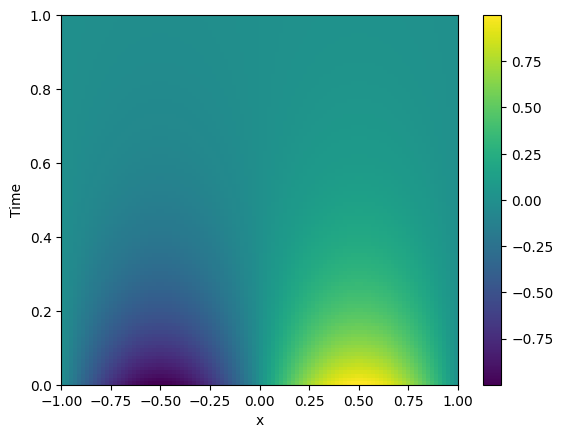

In [3]:
s1, st1 = solveEquationPYPDE('u', f"0.4*laplace(u)", ic='sin(pi*x)', trange=1)
pde.plot_kymograph(st1)

In [4]:
numerical = np.array(st1.data)[:100,:]

In [5]:
x = s1.get_line_data()['data_x'].reshape(-1,1) # X x 1
t = np.array(st1.times).reshape(-1,1) # T x 1
x_grid, t_grid = np.meshgrid(x, t)

u = np.array(st1.data)

##Generate the two indices
idx1 = np.random.choice(x_grid.shape[0], 55, replace=False)
idx1 = np.sort(idx1)
idx2 = np.random.choice(x_grid.shape[1], 50, replace=False)
idx2 = np.sort(idx2)

def gen_train(grid):
    grid_new = grid[idx1]
    grid_new = grid_new[:,idx2]
    return grid_new
    
x_train, t_train, u_train = gen_train(x_grid), gen_train(t_grid), gen_train(u)

In [6]:
## reshape to feed into model
x_train = x_train.flatten()[:,None]
t_train = t_train.flatten()[:,None]

u_train = u_train.flatten()[:,None]
print(x_train.shape, t_train.shape, u_train.shape)

(2750, 1) (2750, 1) (2750, 1)


In [7]:
def preds_and_errors_heat(model):
    pred = model.net(xt_pairs.float())
    preds = pred.reshape((100,100)).detach().cpu()
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, layout='constrained')
    fig.set_figwidth(12)
    #fig.suptitle('Horizontally stacked subplots')
    ax1.set_title("Predicted")
    ax1.set_xlabel("x")
    ax1.set_ylabel("t")
    p1 = ax1.pcolormesh(x_grid.numpy(), t_grid.numpy(), preds.numpy())
    plt.colorbar(p1, ax=ax1)
    ax2.set_title("Error")
    ax2.set_xlabel("x")
    p2 = ax2.pcolormesh(x_grid.numpy(), t_grid.numpy(), np.abs(numerical-preds.numpy()))
    plt.colorbar(p2, ax=ax2)
    plt.show()

In [8]:
## boilerplate stuff for GPU...
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

## create gridmesh for plotting
x_axis = torch.linspace(-1, 1, 100, dtype=torch.float16)
t_axis = torch.linspace(0, 1, 100, dtype=torch.float16)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

class PINN():
    def __init__(self, x, t, u, dDim=256, nHid=4):
        self.x = torch.tensor(x, dtype=torch.float16, requires_grad=True, device=device)
        self.t = torch.tensor(t, dtype=torch.float16, requires_grad=True, device=device)
        
        self.u = torch.tensor(u, dtype=torch.float16, device=device)
        
        self.null = torch.zeros((self.x.shape[0],1), dtype=torch.float16, device=device)
        self.dDim = dDim
        self.nHid = nHid
        self.net_init()
        
        self.optim = torch.optim.Adam(self.net.parameters(), lr=1e-4)
        
        self.mse = torch.nn.MSELoss()
        self.ls = 0
        self.step = 0
    
    def net_init(self, act=torch.nn.Tanh):
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, self.dDim), act(),
            torch.nn.Sequential(*[
                torch.nn.Sequential(*[
                    torch.nn.Linear(self.dDim, self.dDim), act()
            ]) for _ in range(self.nHid)]),
            torch.nn.Linear(self.dDim, 1)
        )
        self.net.to(device)

        for module in self.net.modules():
            if isinstance(module, act):
                module = torch.cuda.amp.autocast()(module)
    
    def func(self, x, t):
        with torch.cuda.amp.autocast():
            u = self.net(torch.hstack((x, t)))
    
            ut = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
            ux = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
            uxx = torch.autograd.grad(ux, x, torch.ones_like(ux), create_graph=True)[0]
                
            f_u = ut - 0.4 * uxx
        return u, f_u
        
    def closure(self):
        self.optim.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            u_pred, f_u_pred = self.func(self.x, self.t)
            u_loss = self.mse(u_pred, self.u)
            f_u_loss = self.mse(f_u_pred, self.null)
            self.ls = u_loss + f_u_loss
        self.ls.backward()

        if not self.step % 100:
            print(f"Step: {self.step}, Loss: {self.ls}")
        
        if self.step in [0,10000,25000,50000]:
            preds_and_errors_heat(self)
        # if not self.step % 1000:
        #     print(f"Step: {self.step}, Loss: {self.ls}")
        #     pred = self.net(xt_pairs.float()).reshape((100,100)).detach().cpu()
        #     plt.pcolormesh(x_grid.numpy(), t_grid.numpy(), pred.numpy())
        #     plt.colorbar()
        #     plt.show()
        self.step += 1
        return self.ls

    def train(self):
        self.net.train()
        for i in range(50001):
            self.optim.step(self.closure)

/home/gallirium/diplom/fbpinns/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step: 0, Loss: 0.058724455535411835


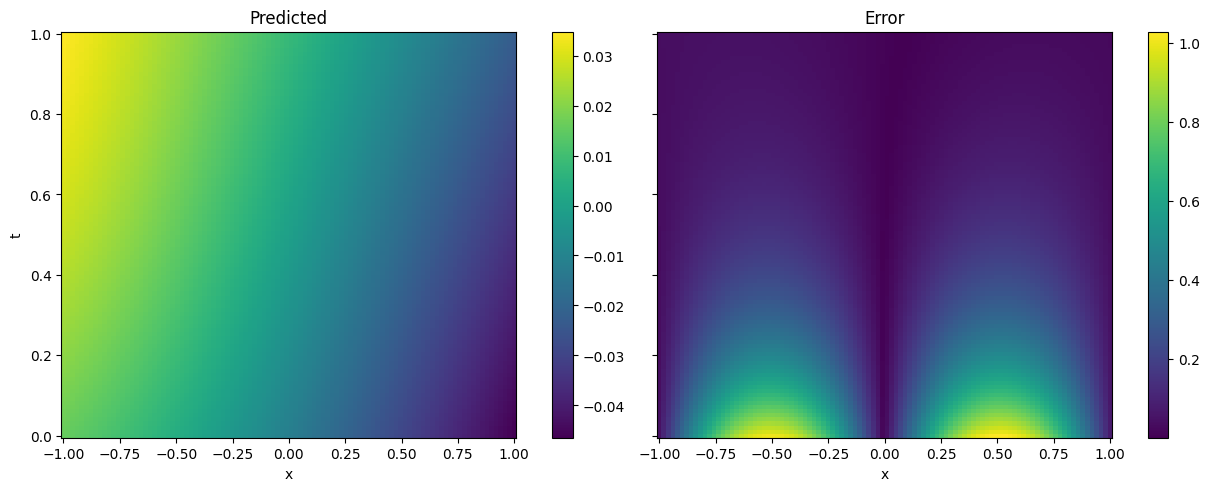

/home/gallirium/diplom/fbpinns/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [2750, 1], strides() = [1, 0]
param.sizes() = [2750, 1], strides() = [1, 0] (Triggered internally at ../torch/csrc/autograd/functions/accumulate_grad.h:219.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step: 100, Loss: 0.02314011938869953
Step: 200, Loss: 0.013764627277851105
Step: 300, Loss: 0.012249624356627464
Step: 400, Loss: 0.011205729097127914
Step: 500, Loss: 0.009765620343387127
Step: 600, Loss: 0.008925792761147022
Step: 700, Loss: 0.008050971664488316
Step: 800, Loss: 0.007404830306768417
Step: 900, Loss: 0.006863683927804232
Step: 1000, Loss: 0.006199059076607227
Step: 1100, Loss: 0.005687458906322718
Step: 1200, Loss: 0.0055914209224283695
Step: 1300, Loss: 0.004816810134798288
Step: 1400, Loss: 0.004538737237453461
Step: 1500, Loss: 0.004343328066170216
Step: 1600, Loss: 0.00394114525988698
Step: 1700, Loss: 0.0037626074627041817
Step: 1800, Loss: 0.003364924807101488
Step: 1900, Loss: 0.003119578119367361
Step: 2000, Loss: 0.003974065184593201
Step: 2100, Loss: 0.002740075346082449
Step: 2200, Loss: 0.002581516047939658
Step: 2300, Loss: 0.002382952254265547
Step: 2400, Loss: 0.002238138811662793
Step: 2500, Loss: 0.0022573971655219793
Step: 2600, Loss: 0.0022350728977

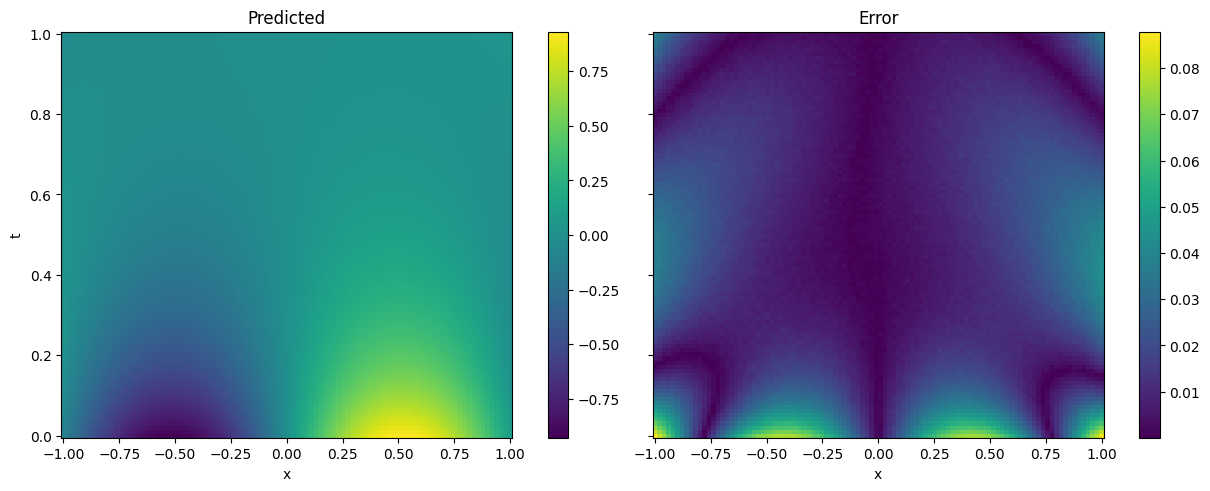

Step: 10100, Loss: 0.00042186418431811035
Step: 10200, Loss: 0.0003955315623898059
Step: 10300, Loss: 0.0004196753725409508
Step: 10400, Loss: 0.00038988719461485744
Step: 10500, Loss: 0.00039132300298660994
Step: 10600, Loss: 0.00040147185791283846
Step: 10700, Loss: 0.0004192336928099394
Step: 10800, Loss: 0.0003528365632519126
Step: 10900, Loss: 0.0003703541588038206
Step: 11000, Loss: 0.00044323765905573964
Step: 11100, Loss: 0.00137902342248708
Step: 11200, Loss: 0.0007630938780494034
Step: 11300, Loss: 0.0003440221189521253
Step: 11400, Loss: 0.00037670996971428394
Step: 11500, Loss: 0.0005780661012977362
Step: 11600, Loss: 0.00031637412030249834
Step: 11700, Loss: 0.00029866036493331194
Step: 11800, Loss: 0.0003200862556695938
Step: 11900, Loss: 0.0006054000114090741
Step: 12000, Loss: 0.0006973386625759304
Step: 12100, Loss: 0.00032722801552154124
Step: 12200, Loss: 0.0007331898086704314
Step: 12300, Loss: 0.0002742851502262056
Step: 12400, Loss: 0.000274136895313859
Step: 1250

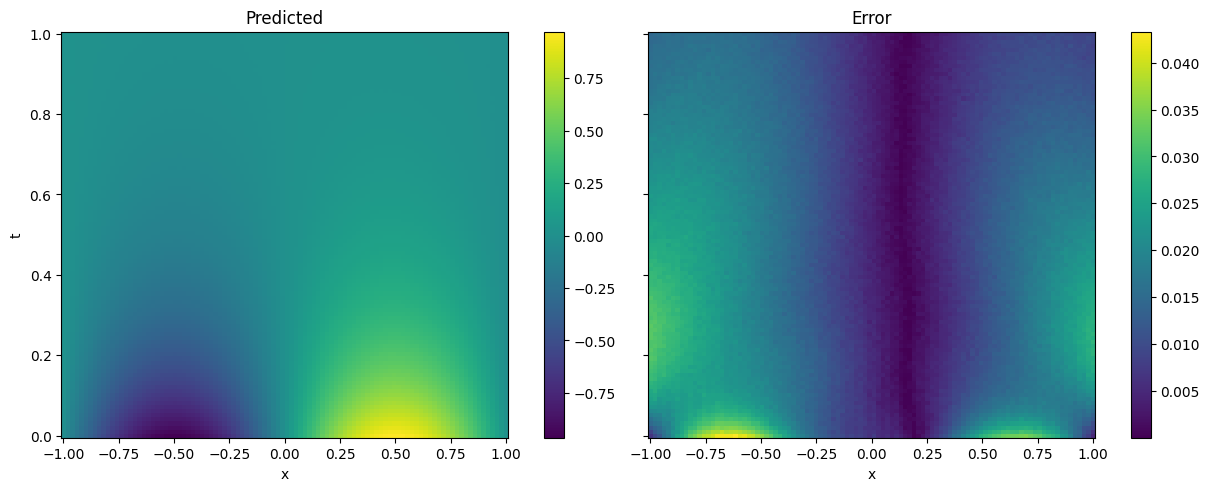

Step: 25100, Loss: 0.00013931999274063855
Step: 25200, Loss: 0.00015489195357076824
Step: 25300, Loss: 0.0003060604212805629
Step: 25400, Loss: 0.00029324390925467014
Step: 25500, Loss: 0.0002043758286163211
Step: 25600, Loss: 0.00021737470524385571
Step: 25700, Loss: 9.972848056349903e-05
Step: 25800, Loss: 0.00011518727114889771
Step: 25900, Loss: 0.00013821295578964055
Step: 26000, Loss: 6.718094664392993e-05
Step: 26100, Loss: 0.00016740435967221856
Step: 26200, Loss: 0.00010868360550375655
Step: 26300, Loss: 0.0001147191142081283
Step: 26400, Loss: 0.00023326942755375057
Step: 26500, Loss: 0.00019581557717174292
Step: 26600, Loss: 4.570707824314013e-05
Step: 26700, Loss: 0.00022914158762432635
Step: 26800, Loss: 0.0003110119141638279
Step: 26900, Loss: 0.00010404069325886667
Step: 27000, Loss: 9.934160334523767e-05
Step: 27100, Loss: 0.0002847993455361575
Step: 27200, Loss: 0.00023712037364020944
Step: 27300, Loss: 0.00014058215310797095
Step: 27400, Loss: 0.00011542794527485967
S

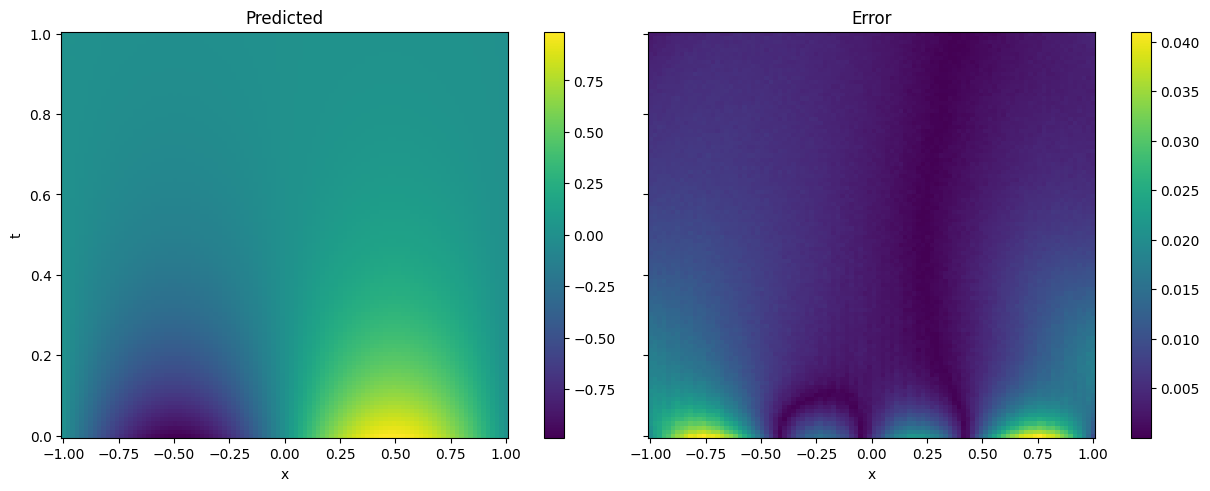

CPU times: user 4min 2s, sys: 9.28 s, total: 4min 12s
Wall time: 4min 20s


In [9]:
%%time
heat = PINN(x_train, t_train, u_train)
heat.train()

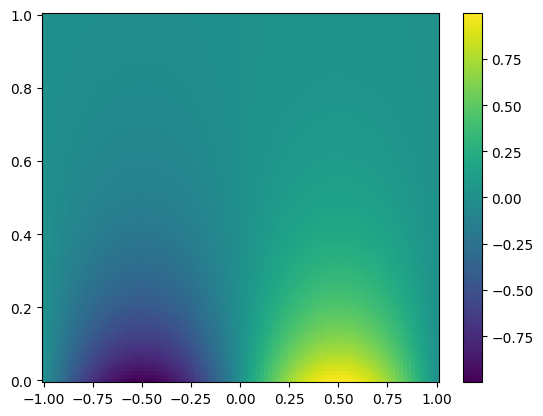

In [10]:
alpha = 0.4
L = 1
n = 1
x = np.linspace(-1,1,100)
t = np.linspace(0,1,100)
xg, tg = np.meshgrid(x, t)
ex = np.exp(-n**2 * np.pi**2 * alpha * tg / L**2)
sine = np.sin(n*np.pi*xg/L)
u = ex*sine

plt.pcolormesh(xg,tg,u)
plt.colorbar()
plt.show()

In [11]:
u.shape

(100, 100)

In [12]:
u_num = np.array(st1.data)[:100,:]

In [13]:
np.mean((u-u_num)**2)

3.219721471688065e-05

%%%%%%%%%%%%%%%
2
%%%%%%%%%%%%%%%
########32##########
Step: 0, Loss: 0.08263777941465378


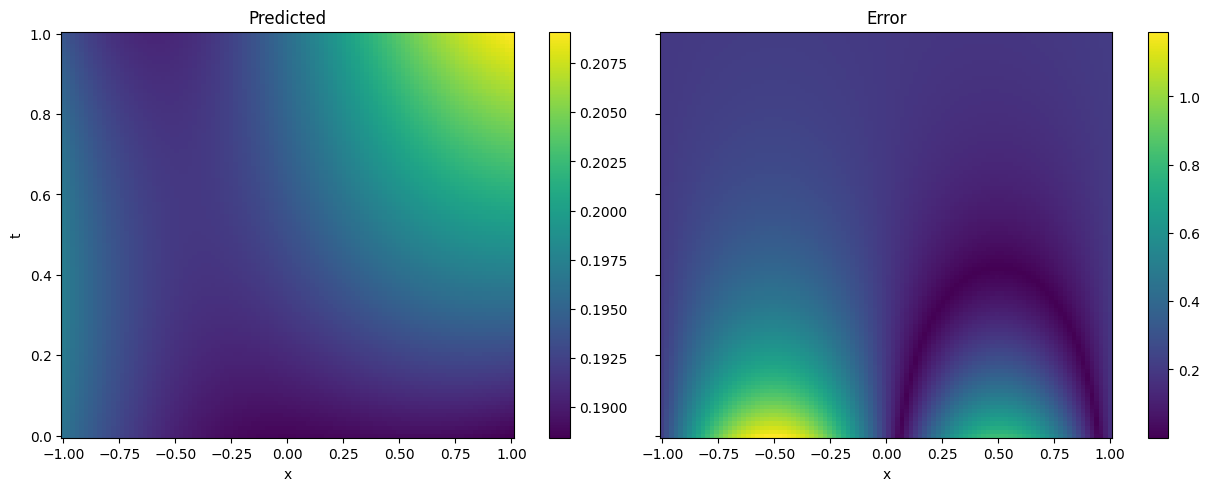

Step: 100, Loss: 0.03833989426493645
Step: 200, Loss: 0.03480686992406845
Step: 300, Loss: 0.033670324832201004
Step: 400, Loss: 0.03294827789068222
Step: 500, Loss: 0.03240177035331726
Step: 600, Loss: 0.031814634799957275
Step: 700, Loss: 0.031104588881134987
Step: 800, Loss: 0.030264277011156082
Step: 900, Loss: 0.029312074184417725
Step: 1000, Loss: 0.0282423235476017
Step: 1100, Loss: 0.026921618729829788
Step: 1200, Loss: 0.025212276726961136
Step: 1300, Loss: 0.0231316015124321
Step: 1400, Loss: 0.020891886204481125
Step: 1500, Loss: 0.018474819138646126
Step: 1600, Loss: 0.015835920348763466
Step: 1700, Loss: 0.013653716072440147
Step: 1800, Loss: 0.012024199590086937
Step: 1900, Loss: 0.01074468158185482
Step: 2000, Loss: 0.00976268108934164
Step: 2100, Loss: 0.008919339627027512
Step: 2200, Loss: 0.008115318603813648
Step: 2300, Loss: 0.007432128768414259
Step: 2400, Loss: 0.006877723149955273
Step: 2500, Loss: 0.00636815931648016
Step: 2600, Loss: 0.00584739726036787
Step: 2

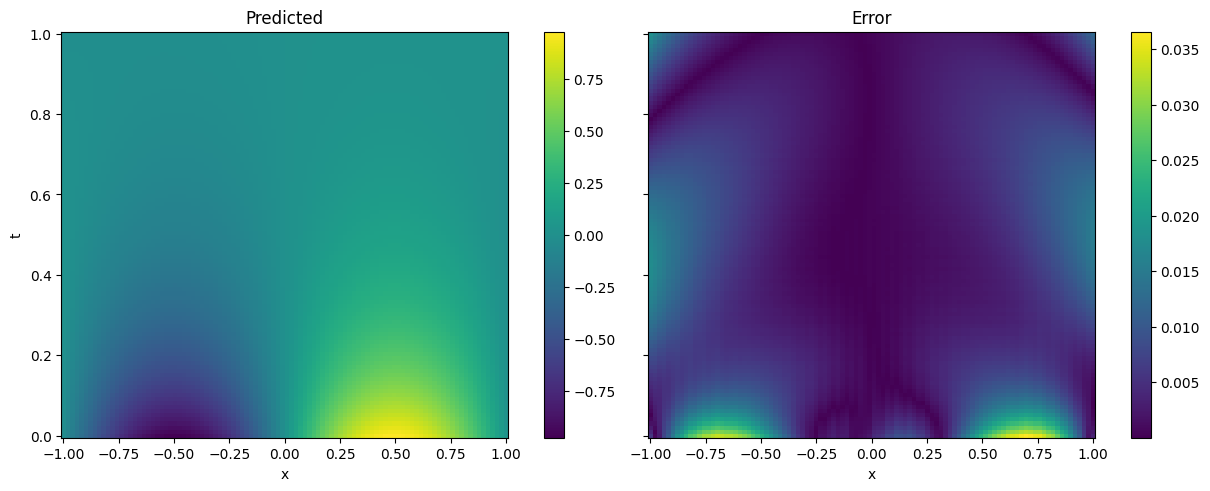

Step: 10100, Loss: 9.935411799233407e-05
Step: 10200, Loss: 8.816811896394938e-05
Step: 10300, Loss: 8.623622852610424e-05
Step: 10400, Loss: 8.396677003474906e-05
Step: 10500, Loss: 8.131871436489746e-05
Step: 10600, Loss: 8.085997251328081e-05
Step: 10700, Loss: 8.079450344666839e-05
Step: 10800, Loss: 7.96044259914197e-05
Step: 10900, Loss: 7.642463606316596e-05
Step: 11000, Loss: 7.450093107763678e-05
Step: 11100, Loss: 7.208225724752992e-05
Step: 11200, Loss: 7.146527786972001e-05
Step: 11300, Loss: 7.024787191767246e-05
Step: 11400, Loss: 6.945665518287569e-05
Step: 11500, Loss: 6.916306301718578e-05
Step: 11600, Loss: 6.702342943754047e-05
Step: 11700, Loss: 6.550102261826396e-05
Step: 11800, Loss: 6.435433169826865e-05
Step: 11900, Loss: 6.791232590330765e-05
Step: 12000, Loss: 6.573593418579549e-05
Step: 12100, Loss: 6.158865289762616e-05
Step: 12200, Loss: 6.78794167470187e-05
Step: 12300, Loss: 5.9143636462977156e-05
Step: 12400, Loss: 5.884383790544234e-05
Step: 12500, Loss

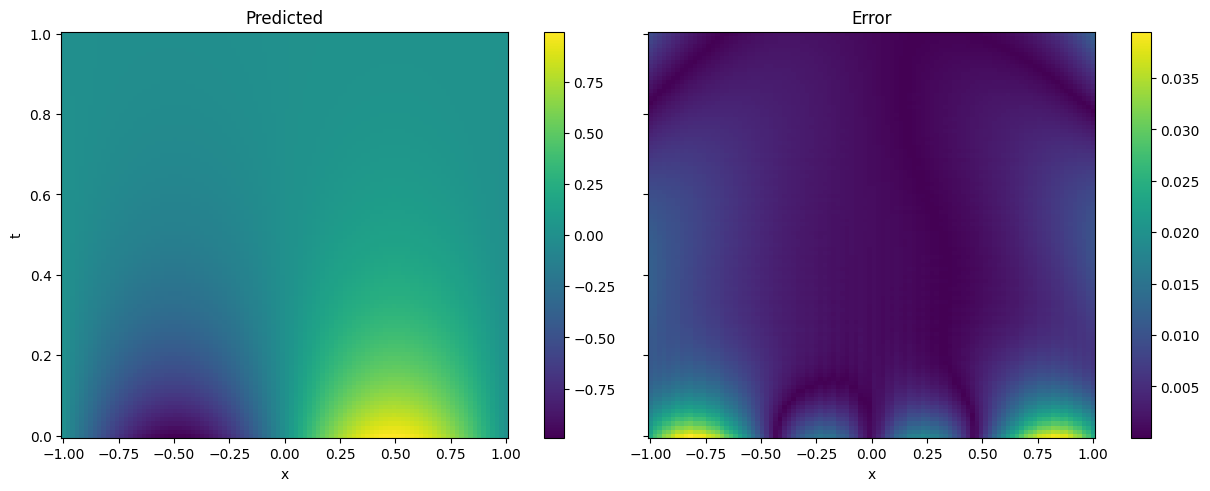

Step: 25100, Loss: 2.3809650883777067e-05
Step: 25200, Loss: 2.8304119041422382e-05
Step: 25300, Loss: 2.385397419857327e-05
Step: 25400, Loss: 2.4210075935116038e-05
Step: 25500, Loss: 2.2622094547841698e-05
Step: 25600, Loss: 2.2851589164929464e-05
Step: 25700, Loss: 2.34089202422183e-05
Step: 25800, Loss: 2.288699397468008e-05
Step: 25900, Loss: 2.3407366825267673e-05
Step: 26000, Loss: 2.31321100727655e-05
Step: 26100, Loss: 3.9668848330620676e-05
Step: 26200, Loss: 2.3604437956237234e-05
Step: 26300, Loss: 2.3727192456135526e-05
Step: 26400, Loss: 2.1997460862621665e-05
Step: 26500, Loss: 2.151098487956915e-05
Step: 26600, Loss: 2.4037644834606908e-05
Step: 26700, Loss: 2.269639662699774e-05
Step: 26800, Loss: 2.3946244255057536e-05
Step: 26900, Loss: 2.2987551346886903e-05
Step: 27000, Loss: 2.1576808649115264e-05
Step: 27100, Loss: 2.2230153263080865e-05
Step: 27200, Loss: 2.1703790480387397e-05
Step: 27300, Loss: 2.1403438950073905e-05
Step: 27400, Loss: 2.322127329534851e-05
S

In [ ]:
import pandas as pd

df = pd.DataFrame(columns=[2,4,6,8,10])
for n_layers in [2,4,6,8,10]:
    print('%%%%%%%%%%%%%%%')
    print(str(n_layers))
    print('%%%%%%%%%%%%%%%')
    tmp = []
    for dim in [32,64,128,256]:
        print('########' + str(dim) + '##########')
        model = PINN(x_train, t_train, u_train, dDim=dim, nHid=n_layers)
        model.train()
        tmp.append(model.ls.item())
    df[n_layers] = pd.Series(tmp)

df